## NOTES:
<ul>
<li>Sections labeled <strong>CORE</strong> must be run in order to begin Aquifer Analysis</li>
<li>Cells labeled <strong>Control</strong> contain inputs for the immeadiately proceeding section(s)</li>
<li>Sections labeled <strong>EXTRA</strong> contain additional plotting or analysis tools but are not necessary for Aquifer Analysis</li>
</ul>

## CORE: Imports

In [72]:
#Python3.10
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as cx
import requests
import calendar
from importlib import reload
from typing import IO

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

# TODO: Look into the warning that this is disabling. It doesn't appear to be significant for the purposes of this code but should be understood
pd.options.mode.chained_assignment = None

#pd.options.mode.chained_assignment = 'warn'

## CORE: Single Site Data<br>
This function produces the streamflow analysis (using the functions above) for a single site given a list of thresholds and time windows to analyze

Controls:

In [65]:
import Src.classes as cl
import Src.func as fn
reload(cl)

# df2 holds all-time data, df is analyzed range
curr_guage = cl.SRB_Guage
df = nwis.get_record(sites=cl.SRB_Guage.id, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=fn.DEFAULT_START, end='2014-09-30')
df2 = nwis.get_record(sites=curr_guage.id, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=fn.DEFAULT_START, end='2014-09-30')

# Set to true if running indepedently to verify data with Kocis paper (or other source)
# Set to false if running Aquifer Analysis
testing = False

Single Site Analysis:

In [66]:
# If looking at a post impairment period, but calculating threshold based on the full record of data, pass a second dataframe with a different 
# start/end date as the final parameter. This method was used in Kocis 2017 and is needed for some data verification, but is not the methodology
# used for the Aquifer Analysis and so *args will most often be empty.
import Src.func as fn
reload(fn)

def single_site_data(df: pd.DataFrame, quantiles_list: list, data_ranges_list: list, *args):
    df = df.reset_index()    
    threshold = None
    df_complete_site_data = pd.DataFrame()    
    df_complete_mk_mag = pd.DataFrame()
    df_complete_mk_dur = pd.DataFrame()
    df_complete_mk_intra = pd.DataFrame()
    
    for data_range in data_ranges_list:
        for quantile in quantiles_list:
            # Copying original dataframe to avoid any conflicts
            df_copy = df.copy()
            
            # Validate that site is not missing > 10% of data
            date_threshold = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)              
            
            # Filter dataframe based on current data_range (don't do this during testing if testing unique dataset/range)
            if not testing:
                df_copy = df_copy[df_copy['datetime'].dt.date >= date_threshold]
            
            # Validate <10% missing data based on filtered dataframe
            missing = fn.validate(df_copy, date_threshold, fn.DEFAULT_END)
            valid = missing < fn.MAX_MISSING_THRESHOLD                               
    
            # Check for optional second dataframe containing full record
            if args and isinstance(args[0], pd.DataFrame) and not args[0].empty:
                #print('Threshold calculation across the full record')
                df2 = args[0].reset_index()
                threshold = fn.calc_threshold(df2, quantile)
                # threshold = 52350 # SRB_Guage post-impairment threshold for verification with Kocis_2017 
            else:
                #print('Threshold calculation across a limited record')
                threshold = fn.calc_threshold(df_copy, quantile)                             

            # Create a dataframe with only days over HMF threshold as well as continuous dataframe for MK trend test
            hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_copy, threshold)
            #print(zero_deflated_hmf)
            
            # Aggregate data before performing MK magnitude test
            df_agg_cont = hmf_series_cont.copy()
            df_agg_cont = fn.convert_hmf(df_agg_cont, threshold)
            df_agg_cont['00060_Mean'] = df_agg_cont['00060_Mean'].apply(lambda x: x * fn.CUBIC_FT_KM_FACTOR if x >= 0 else 0)
            df_agg_cont.set_index('datetime', inplace=True)
            df_agg_cont = df_agg_cont.resample(fn.HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
            df_agg_cont.columns = ['Sum', 'Count']
            df_agg_cont_defl = df_agg_cont[df_agg_cont['Sum'] > 0]          
            
            # MK Magnitude
            df_mk_mag = fn.mann_kendall(df_agg_cont_defl['Sum'], df_agg_cont['Sum'], fn.MK_TREND_ALPHA)

            # Find number of years with HMF (10 for October 1st)
            hmf_years = fn.num_hmf_years(hmf_series_defl, 10)            

            # Mask out months that don't fall within 3 and 6 month Winter range
            df_six_month, df_three_month = fn.three_six_range(hmf_series_defl, 12, 2, 11, 4)

            # Convert to daily average flow in cfpd, and take only flow above the threshold
            hmf_series_defl = fn.convert_hmf(hmf_series_defl, threshold)
            total_hmf_flow = hmf_series_defl["00060_Mean"].sum()
            hmf_per_month = fn.monthly_hmf(hmf_series_defl, data_range, quantile)

            # Calculate 3 and 6 month HMF
            df_six_month = fn.convert_hmf(df_six_month, threshold)
            six_month_hmf = df_six_month["00060_Mean"].sum()
            df_three_month = fn.convert_hmf(df_three_month, threshold)
            three_month_hmf = df_three_month["00060_Mean"].sum()
            
            total_hmf_flow = (total_hmf_flow * fn.CUBIC_FT_KM_FACTOR) / hmf_years
            six_month_hmf = (six_month_hmf * fn.CUBIC_FT_KM_FACTOR) / hmf_years
            three_month_hmf = (three_month_hmf * fn.CUBIC_FT_KM_FACTOR) / hmf_years

            # Inter-annual
            hmf_series_full, _ = fn.filter_hmf(df_copy, threshold)
            hmf_years_full = fn.num_hmf_years(hmf_series_full, 10)

            delta = df_copy['datetime'].max().year - df_copy['datetime'].min().year
            inter_annual = (hmf_years_full / delta)

            # Average Duration and Intra-annual Frequency
            hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)
            event_duration, annual_duration, intra_annual, event_hmf, df_results = fn.calc_duration_intra_annual(hmf_series_cont, hmf_years)
            dur_series_defl = df_results['duration'][df_results['duration'] > 0]
            dur_series_cont = df_results['duration']
            df_mk_dur = fn.mann_kendall(dur_series_defl, dur_series_cont, fn.MK_TREND_ALPHA)
                        
            intra_series_defl = df_results['total_events'][df_results['total_events'] > 0]
            intra_series_cont = df_results['total_events']
            df_mk_intra = fn.mann_kendall(intra_series_defl, intra_series_cont, fn.MK_TREND_ALPHA) 
            
            # Timing Calculation using DOHY
            timing = fn.calc_timing(hmf_series_defl)           

            # TODO: One-day peaks (avg. # of times hmf occurs on one day only)          
            
            # Merging site dataframe with Mann-Kendall dataframe. This start date is the beginning of the actual data, not necessarily 
            # the beginning of the analyzed range. Validation (above) starts from the start of the official range (1970/90-2020)
            start = df_copy['datetime'].min().date()
            end = df_copy['datetime'].max().date()
            data = {'dataset_ID': (data_range * quantile), 'site_no': df_copy.iloc[0]['site_no'], 'analyze_start': start, 'analyze_end': end, 'analyze_range': delta, 'quantile': quantile, 
                    'valid': valid, 'missing': missing, 'threshold': threshold, 'hmf_years': hmf_years, 'annual_hmf': total_hmf_flow, 'six_mo_hmf': six_month_hmf, 'three_mo_hmf': three_month_hmf, 
                    'annual_duration': annual_duration, 'event_duration': event_duration, 'event_hmf': event_hmf, 'inter_annual': inter_annual, 'intra_annual': intra_annual, 'timing': timing}              
            
            # Merging MK magnitiude
            df_mk_mag.insert(0, 'dataset_ID', data_range * quantile)
            df_mk_mag.insert(1, 'site_no', df_copy.iloc[0]['site_no'])
            df_complete_mk_mag = pd.concat([df_complete_mk_mag.reset_index(drop=True), df_mk_mag.reset_index(drop=True)], axis=0) 
            
            # Merging MK duration
            df_mk_dur.insert(0, 'dataset_ID', data_range * quantile)
            df_mk_dur.insert(1, 'site_no', df_copy.iloc[0]['site_no'])
            df_complete_mk_dur = pd.concat([df_complete_mk_dur.reset_index(drop=True), df_mk_dur.reset_index(drop=True)], axis=0)   
            
            # Merging MK intra-annual
            df_mk_intra.insert(0, 'dataset_ID', data_range * quantile)
            df_mk_intra.insert(1, 'site_no', df_copy.iloc[0]['site_no'])
            df_complete_mk_intra = pd.concat([df_complete_mk_intra.reset_index(drop=True), df_mk_intra.reset_index(drop=True)], axis=0)        
            
            # Merging metric results
            df_single_iteration = pd.DataFrame(data, index=['0'])
            df_single_iteration = pd.concat([df_single_iteration.reset_index(drop=True), hmf_per_month.reset_index(drop=True)], axis=1)
            df_complete_site_data = pd.concat([df_complete_site_data.reset_index(drop=True), df_single_iteration.reset_index(drop=True)], axis=0)
        
    return df_complete_site_data, df_complete_mk_mag, df_complete_mk_dur, df_complete_mk_intra

# For testing purposes, to run this cell independently
df_complete_site_data, df_complete_mk_mag, df_complete_mk_dur, df_complete_mk_intra = single_site_data(df, fn.QUANTILE_LIST, fn.DATA_RANGE_LIST)

'''
try:
    with pd.ExcelWriter('df_single_site.xlsx') as writer:
        df_complete_site_data.to_excel(writer, sheet_name='site_metrics', index=False)
        df_complete_mk_mag.to_excel(writer, sheet_name='mk_magnitude', index=False)
        df_complete_mk_intra.to_excel(writer, sheet_name='mk_intra', index=False)
        df_complete_mk_dur.to_excel(writer, sheet_name='mk_duration', index=False)
except Exception as e:
    print(e)
'''
   
fn.single_site_report(df_complete_site_data)
df_complete_site_data = fn.gages_2_filtering(df_complete_site_data)
#fn.save_data(df_complete_site_data, df_complete_mk_mag, df_complete_mk_dur, df_complete_mk_intra, 'TEST')


Site No: 0    11447650
1    11447650
2    11447650
0    11447650
Name: site_no, dtype: object
Analyzed Range: 24
24
44
44
Quantile: 0.90
0.95
0.90
0.95
Valid: False
False
False
False
% Missing: 0.199963
0.199963
0.119976
0.119976
90%: 47100.0
68300.0
49900.0
69400.0
HMF Years: 16
12
28
23
Annual Duration: 54.750000
36.500000
57.357143
34.739130
Event Duration: 20.776042
16.370833
23.264881
13.034369
Event HMF: 1.102463
0.345665
1.151843
0.278920
Inter-annual Frequency: 0.666667
0.500000
0.636364
0.522727%
Intra-annual Frequency: 2.750000
2.250000
2.714286
2.826087
Total HMF in km^3/year: 2.739721
0.790387
2.743677
0.749886
Center of Mass: 144.437500
152.416667
139.571429
145.086957
6 Month HMF in km^3/year: 2.491944
0.745227
2.584929
0.726846
3 Month HMF in km^3/year: 1.502870
0.500732
1.527563
0.481837


## CORE: Multi-Site Filtering<br>
This function creates the list of sites to analyze by filtering the complete list of state sites with 00060_Mean data down to those that lie within a specific watershed boundary using decimal long/lat positional data and a region shapefile (e.g. state or watershed boundary)<br><br>

Controls:

In [67]:
# This is only needed when running the following cell independently
shapefile_path = 'ShapeFiles/Aquifers/Central_Valley/HUC4/NHD_H_1802'

Site List Generation:

In [68]:
def filter_state_site(shapefile_path: str, state_uri: str):
    """Creates a list of sites with over 50 years of 00060_Mean streamflow data for a given region"""
    # Request page from USGS site, ignore all informational lines
    response = requests.get(state_uri)
    data = response.text
    lines = data.splitlines()
    lines = [line for line in lines if not line.startswith('#')]

    # Create dataframe where site_no is a list of all sites in a state with 00060 data
    tsd = "\n".join(lines)
    df = pd.read_csv(StringIO(tsd), sep='\t')
    df_state_sites = df.iloc[1:]
        
    # Filter out sites outside of HU boundary
    if fn.SORT_BY_WB:
        shapefile = gpd.read_file(shapefile_path)
        df_state_sites['geometry'] = [Point(lon, lat) for lon, lat in zip(df_state_sites['dec_long_va'], df_state_sites['dec_lat_va'])]
        gdf_data = gpd.GeoDataFrame(df_state_sites, crs=shapefile.crs)
        df_state_sites = gpd.sjoin(gdf_data, shapefile, predicate='within')
            
    #print(df_state_sites.columns.to_list())
    #print(df_state_sites)
    
    return df_state_sites

df_state_sites = filter_state_site(shapefile_path, fn.SITES_URI)
print(f'Total Sites: {len(df_state_sites)} in the state of {fn.STATE_CODE.upper()} in the given WB')
site_list = df_state_sites['site_no'].to_list()
print(site_list)

Total Sites: 57 in the state of CA in the given WB
['11337080', '11342000', '11345500', '11348500', '11355010', '11355500', '11370500', '11370700', '11372000', '11374000', '11376000', '11376550', '11377100', '11379500', '11381500', '11383500', '11389500', '11390000', '11390500', '11401920', '11402000', '11413000', '11418500', '11421000', '11424000', '11425500', '11427000', '11446500', '11447360', '11447650', '11447830', '11447850', '11447890', '11447905', '11448750', '11448800', '11449255', '11449500', '11451000', '11451100', '11451300', '11451715', '11451800', '11452500', '11452800', '11452900', '11453000', '11453500', '11453590', '11454000', '11455095', '11455140', '11455280', '11455315', '11455338', '11455385', '11455420']


## CORE: Multi-Site Data Creation<br>
This function uses the list generated by the previous section to generate single site data for every site in the list, and validate that no site is missing more than 10% of its data

In [69]:
# REQUIRES: 'df_state_sites' from 'Multi-Site Filtering'
# Used for now to limit runtime when running independently
site_limit = 3

def create_multi_site_data(df_state_sites: pd.DataFrame, site_limit: int, aquifer: cl.Aquifer):
	"""Generates detailed HMF, MK, and POS information for each site in the passed dataframe"""
	# Necessary for proper iterrows() behavior
	df_state_sites.reset_index(drop=True, inplace=True)

	# Creating the dataframe that will hold final results for mapping
	df_multi_site_metric = pd.DataFrame()
	df_multi_site_mk_mag = pd.DataFrame()
	df_multi_site_mk_dur = pd.DataFrame()
	df_multi_site_mk_intra = pd.DataFrame()
 
	site_blacklist = []

	for index, row in df_state_sites.iterrows():
		while index < site_limit:
      
			if str(row['site_no']) in aquifer.blacklist:
				print(f'IGNORED: Site {row["site_no"]} is in aquifer blacklist')
				break
			
			# Create a dataframe for the current site in the iteration to perform calculations on
			df = nwis.get_record(sites=row['site_no'], service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=fn.DEFAULT_START, end=fn.DEFAULT_END)
			df = df.reset_index()
			
			# Confirm that dataframe is not empty and has the required streamflow data before continuing
			if df.empty:
				site_blacklist.append(row['site_no'])
				print(f'IGNORED: No data for site {row["site_no"]}')
				break

			if '00060_Mean' not in df.columns:
				site_blacklist.append(row['site_no'])
				print(f'IGNORED: No 00060_Mean data for site {row["site_no"]}')
				break
			
			# Filter out sites with less than the minimum required range of data
			start = df['datetime'].min().date()
			end = df['datetime'].max().date()
			range = round((end - start).days / 365.25, 1)
			
			# Ignore sites with less than the minimum required years of data
			if range < fn.MIN_DATA_PERIOD:
				site_blacklist.append(row['site_no'])
				print(f'IGNORED: Not enough data for site {row["site_no"]}')
				break			
				
			df_single_site_metric, df_mk_mag, df_mk_dur, df_mk_intra = single_site_data(df, fn.QUANTILE_LIST, fn.DATA_RANGE_LIST)			
			
			# Append positional data to dataframe created by single_site_data()
			add_data = {'dec_lat_va': row['dec_lat_va'], 'dec_long_va': row['dec_long_va'], 'data_start': start, 'data_end': end, 'total_record': range}			
			add_data = pd.DataFrame(add_data, index=['0'])
   
			# Duplicates the rows of add_data so that positional information is passed to each individual dataframe when this frame is split
			add_data = pd.DataFrame(np.tile(add_data.values, (len(df_single_site_metric), 1)), columns=add_data.columns)
			df_single_site_metric = pd.concat([df_single_site_metric.reset_index(drop=True), add_data.reset_index(drop=True)], axis=1)

			# Append single site data to multi-site dataframes
			df_multi_site_metric = pd.concat([df_multi_site_metric, df_single_site_metric], ignore_index=True)
			df_multi_site_mk_mag = pd.concat([df_multi_site_mk_mag, df_mk_mag], ignore_index=True)
			df_multi_site_mk_dur = pd.concat([df_multi_site_mk_dur, df_mk_dur], ignore_index=True)
			df_multi_site_mk_intra = pd.concat([df_multi_site_mk_intra, df_mk_intra], ignore_index=True)   
   		
			print(f'Added site {index + 1} of {len(df_state_sites)}')
			
			#clear_output(wait=True)
			#time.sleep(0.500)
			break

	return df_multi_site_metric, df_multi_site_mk_mag, df_multi_site_mk_dur, df_multi_site_mk_intra, site_blacklist


df_multi_site_metric, df_multi_site_mk_mag, df_multi_site_mk_dur, df_multi_site_mk_intra, site_blacklist = create_multi_site_data(df_state_sites, site_limit, cl.central_valley_aquifer)
df_multi_site, df_invalid_site = fn.filter_by_valid(df_multi_site_metric)
#df_multi_site.to_csv('df_multi_site.csv')
#print(df_multi_site)

print(f'Max HMF for this region: {df_multi_site["annual_hmf"].max():.1f}')
print(f'{len(df_multi_site)} site(s) valid out of {len(df_multi_site_metric)}')

IGNORED: No data for site 11337080
Added site 2 of 57
Added site 3 of 57
Max HMF for this region: 0.2
8 site(s) valid out of 8


## CORE: Aquifer Analysis
This section generates aquifer-wide data based on all watershed boundary shapefiles that intersect with the aquifer boundary. In addition it contains a section to generate a map of this aquifer boundary, the intersecting watershed boundaries, and their relevant water gauge sites and annual high magnitude flows<br><br>
Aquifer Analysis Controls:

In [75]:
# Set the aquifer to collect data for
curr_aquifer = cl.arizona_alluvial_aquifer

# Limit saved sites for testing purposes
# Set to >=999 to analyze all sites
site_limit = 999

Data Creation: 
<li>This code is time-consuming and can be bypassed if a spreadsheet for an aquifer already exists and all that is desired is a plot based on that data</li>

In [76]:
# Data Creation
df_aq_sites_metric = pd.DataFrame()
df_aq_sites_mk_mag = pd.DataFrame()
df_aq_sites_mk_dur = pd.DataFrame()
df_aq_sites_mk_intra = pd.DataFrame()
master_blacklist = []

outer = "outer"
for root, dirs, files in os.walk(curr_aquifer.wb_dir):
    #print(root, dirs, files)
    if os.path.basename(root).startswith('NHD_H_'):
        if curr_aquifer.wb_shapefiles in files:
            shapefile_aq_path = os.path.join(root, curr_aquifer.wb_shapefiles)
            ws_gdf = gpd.read_file(shapefile_aq_path)
            ws_gdf = ws_gdf.to_crs(4269)           
            print("Path: ", shapefile_aq_path)
            
            for state_code in curr_aquifer.states:
                print("Trying: ", state_code)
                try:
                    state_uri = fn.create_state_uri(state_code, fn.PARAM_CODE)
                    df_state_sites = filter_state_site(shapefile_aq_path, state_uri)
                    df_temp_metric, df_temp_mk_mag, df_temp_mk_dur, df_temp_mk_intra, blacklist = create_multi_site_data(df_state_sites, site_limit, curr_aquifer)
                    master_blacklist.extend(blacklist)
                    df_temp_metric['State'] = state_code
                    df_aq_sites_metric = pd.concat([df_aq_sites_metric, df_temp_metric], axis=0, ignore_index=True).reset_index(drop=True)
                    df_aq_sites_mk_mag = pd.concat([df_aq_sites_mk_mag, df_temp_mk_mag], axis=0, ignore_index=True).reset_index(drop=True)
                    df_aq_sites_mk_dur = pd.concat([df_aq_sites_mk_dur, df_temp_mk_dur], axis=0, ignore_index=True).reset_index(drop=True)
                    df_aq_sites_mk_intra = pd.concat([df_aq_sites_mk_intra, df_temp_mk_intra], axis=0, ignore_index=True).reset_index(drop=True)                    
                     
                except Exception as e:
                    print("ERROR: ", e)
                    print(state_uri)

# Filtering out invalid sites by data range and duplicates as some sites are listed in 2+ states   
# Also adds a column to indicate presence in HCDN-2009
#df_aq_sites = df_aq_sites.drop_duplicates(subset=['site_no'])
df_aq_sites_metric = fn.gages_2_filtering(df_aq_sites_metric)

try:
    with open(f'Prelim_Data/{curr_aquifer.name}_Blacklist.txt', 'w') as f:
        master_blacklist = ["'" + str(x) + "'" for x in master_blacklist]        
        f.write(', '.join(master_blacklist))
except Exception as e:
    print(e)
    
#df_aq_sites_metric.to_csv(f'{curr_aquifer.name}_Raw.csv') 

fn.save_data(df_aq_sites_metric, df_aq_sites_mk_mag, df_aq_sites_mk_dur, df_aq_sites_mk_intra, curr_aquifer.name)  
#print(df_aq_sites)

Path:  ShapeFiles/Aquifers/Arizona_Alluvial/HUC4\NHD_H_1501\WBDHU4.shp
Trying:  AZ
Added site 1 of 11
IGNORED: Not enough data for site 09403850
IGNORED: Not enough data for site 09404104
IGNORED: Not enough data for site 09404115
IGNORED: Not enough data for site 09404200
IGNORED: Not enough data for site 09404208
IGNORED: Not enough data for site 09404222
IGNORED: Not enough data for site 09404343
IGNORED: Not enough data for site 09413700
Added site 10 of 11
Added site 11 of 11
Trying:  CA
Trying:  NM
Path:  ShapeFiles/Aquifers/Arizona_Alluvial/HUC4\NHD_H_1503\WBDHU4.shp
Trying:  AZ
Added site 1 of 49
IGNORED: Not enough data for site 09423560
IGNORED: No data for site 09424380
IGNORED: Not enough data for site 09424447
Added site 5 of 49
IGNORED: Not enough data for site 09424580
IGNORED: Not enough data for site 09424600
Added site 8 of 49


c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)


Added site 9 of 49
IGNORED: Not enough data for site 09426620
Added site 11 of 49
Added site 12 of 49
Added site 13 of 49
Added site 14 of 49
IGNORED: Not enough data for site 09429030
IGNORED: Not enough data for site 09429070
Added site 17 of 49
Added site 18 of 49
Added site 19 of 49
Added site 20 of 49
IGNORED: Not enough data for site 09429500
IGNORED: Not enough data for site 09429600
IGNORED: No data for site 09520900


c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)


Added site 24 of 49
IGNORED: Not enough data for site 09522400
Added site 26 of 49
Added site 27 of 49
Added site 28 of 49
IGNORED: Not enough data for site 09522860
IGNORED: Not enough data for site 09522880
IGNORED: Not enough data for site 09522900
Added site 32 of 49
IGNORED: Not enough data for site 09523200
Added site 34 of 49
Added site 35 of 49
Added site 36 of 49
Added site 37 of 49
IGNORED: Not enough data for site 09524700
Added site 39 of 49
Added site 40 of 49
IGNORED: Not enough data for site 09526000
IGNORED: Not enough data for site 09526200
IGNORED: Not enough data for site 09528200
Added site 44 of 49
IGNORED: Not enough data for site 09529000
Added site 46 of 49
Added site 47 of 49
IGNORED: Not enough data for site 09530100
IGNORED: Not enough data for site 09530500
Trying:  CA
Added site 1 of 20
Added site 2 of 20
Added site 3 of 20
Added site 4 of 20
Added site 5 of 20
Added site 6 of 20
IGNORED: Not enough data for site 09429500
IGNORED: Not enough data for site 0

c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)


Added site 9 of 20
Added site 10 of 20
IGNORED: Not enough data for site 09523200
Added site 12 of 20
Added site 13 of 20
Added site 14 of 20
Added site 15 of 20
IGNORED: Not enough data for site 09524700
Added site 17 of 20
IGNORED: Not enough data for site 09526200
Added site 19 of 20
IGNORED: Not enough data for site 09530500
Trying:  NM
Path:  ShapeFiles/Aquifers/Arizona_Alluvial/HUC4\NHD_H_1504\WBDHU4.shp
Trying:  AZ
Added site 1 of 15
Added site 2 of 15
IGNORED: Not enough data for site 09439000
Added site 4 of 15
Added site 5 of 15
Added site 6 of 15
Added site 7 of 15
IGNORED: Not enough data for site 09446320
Added site 9 of 15
Added site 10 of 15
IGNORED: Not enough data for site 09447800
Added site 12 of 15
IGNORED: No 00060_Mean data for site 09457000
Added site 14 of 15
Added site 15 of 15
Trying:  CA
Trying:  NM
IGNORED: Not enough data for site 09430010
IGNORED: Not enough data for site 09430020
IGNORED: Not enough data for site 09430030
Added site 4 of 9
Added site 5 of

c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)
c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)


Added site 8 of 29
IGNORED: Not enough data for site 09517490
IGNORED: Not enough data for site 09519000
IGNORED: Not enough data for site 09519501


c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)


Added site 12 of 29
IGNORED: Not enough data for site 09520280


c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)
c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\pymannkendall\pymannkendall.py:155: RuntimeWarning: invalid value encountered in subtract
  d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)


Added site 14 of 29
IGNORED: Not enough data for site 09522660
IGNORED: Not enough data for site 09522680
IGNORED: Not enough data for site 09522700
IGNORED: Not enough data for site 09522710
IGNORED: Not enough data for site 09522720
IGNORED: Not enough data for site 09522730
IGNORED: Not enough data for site 09522740
IGNORED: Not enough data for site 09522750
IGNORED: Not enough data for site 09522760
IGNORED: Not enough data for site 09522770
IGNORED: Not enough data for site 09522800
IGNORED: Not enough data for site 09522850
Added site 27 of 29
Added site 28 of 29
Added site 29 of 29
Trying:  CA
Trying:  NM
Path:  ShapeFiles/Aquifers/Arizona_Alluvial/HUC4\NHD_H_1508\WBDHU4.shp
Trying:  AZ
IGNORED: Not enough data for site 09535900
Added site 2 of 3
Added site 3 of 3
Trying:  CA
Trying:  NM


## EXTRA: Mann-Kendall Plot
This plots Mann-Kendall trend lines taken from a completed aquifer spreadsheet but is not used in the overall Aquifer Analysis<br><br>
Controls:

In [19]:
# Must be a 30-year date range dataset
mkdataset = 'Upper_Clairborne_30_90.xlsx'
mkdatapath = f'Prelim_Data/{mkdataset}'

Mann-Kendall Plotting:

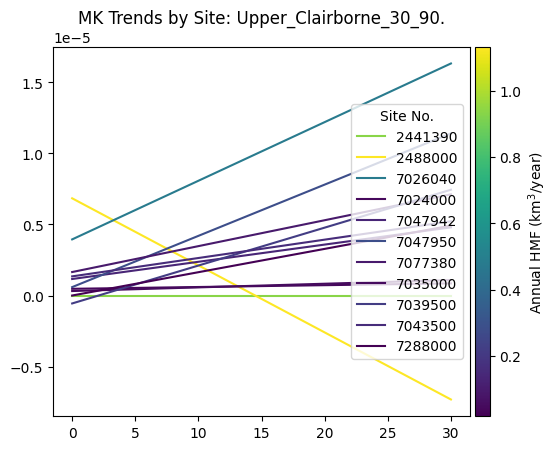

In [26]:
# REQUIRES: 'df_multi_site' from 'Gages-II Filter' OR a spreadsheet for testing
df_mk = pd.read_excel(io=mkdatapath, sheet_name='mk_magnitude')
df_metrics = pd.read_excel(io=mkdatapath, sheet_name='site_metrics')

def create_mk_plot(df_mk: pd.DataFrame, df_metrcis: pd.DataFrame):
    """Create a plot showing Mann-Kendall trends by site"""
    # Filter only sites that show a trend
    df_mk.reset_index(drop=True, inplace=True)
    df_metrcis.reset_index(drop=True, inplace=True)
    
    # Filter out sites with no trend, and merge with metrics 
    df_mk = df_mk[df_mk['mk_h'] == True]    
    df_merged = pd.merge(df_metrics, df_mk, on='site_no', how='inner')     

    fig, ax = plt.subplots()

    vmin = df_merged['annual_hmf'].min()
    vmax = df_merged['annual_hmf'].max()
    norm = mcolors.Normalize(vmin, vmax)
    cmap = 'viridis'
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(df_merged['annual_hmf'])

    for _, row in df_merged.iterrows():
        slope = row['mk_slope']
        intercept = row['mk_int']
        val = row['annual_hmf']
        
        x = np.linspace(0, 30)
        y = slope * x + intercept
        ax.plot(x, y, label=row['site_no'], color=mappable.to_rgba(val))
        
    ax.set_title(f'MK Trends by Site: {mkdataset[:-4]}')
    ax.legend(title='Site No.')
    #ax.axes.get_yaxis().set_ticks([])
    plt.colorbar(mappable, label='Annual HMF ($\mathregular{km^3}$/year)', ax=ax, pad=0.01, aspect=25, orientation='vertical', alpha=1.0)
    #ax.axhline(0, color='black', linewidth=1)
    #ax.axvline(0, color='black', linewidth=1)
    plt.show()

create_mk_plot(df_mk, df_metrics)
